<a href="https://colab.research.google.com/github/chavgova/Brain/blob/main/2_obj_data/all_data/EEG_11_normalized_std_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import codecs
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from matplotlib import pyplot as plt
import math
import numpy as np
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from scipy import signal
import scipy.io as scio
import pandas as pd
from scipy.signal import hilbert
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

In [ ]:
dataset_folder_path = '/content/drive/MyDrive/Brain/EEG_data/Bands/'
model_path = '/content/drive/MyDrive/Brain/EEG_Models/'
model_name = 'EEG_11_model_3d_conv_norm_STD'
channels_list = ['c3', 'c4', 'f3', 'f4', 'p3', 'p4']  # file names format 'c3_input_alpha.txt'
values_per_file = 39000
values_per_split = 9750
fs = 256 # Hz
# object_num = 4
channel_num = len(channels_list)

# Creating the DATASET

In [ ]:
dataset_files_list = [] 
dataset_files_list = os.listdir(dataset_folder_path)

print(dataset_files_list)
object_num = len(dataset_files_list)

['eeg_bands_object_1_fear', 'eeg_bands_object_2_joy', 'eeg_bands_object_1_joy', 'eeg_bands_object_2_fear']


In [ ]:
label_list = []

for item in dataset_files_list:
  if 'joy' in item:
    label_list.append('joy')
  elif 'fear' in item:
    label_list.append('fear')
print(label_list)    

['fear', 'joy', 'joy', 'fear']


# fs=256 Hz
Theta - 4 - 7.5 Hz

Alpha - 8 - 13.5 Hz

Beta -  14 - 30 Hz

Gamma - 30.5 - 40 Hz

In [ ]:
def formatDataFromTXT(contents):
  contents_list = contents.splitlines()
  contents_array = np.array([])

  contents_array = np.array([float(a) for a in contents_list])
  a = int((contents_array.shape[0]-values_per_file)/2)
  contents_array = contents_array[a:-a]  ##############
  
  return contents_array 

def ReadObjectData(object_folder_name):
  object_data_3d = np.empty((channel_num, 4, values_per_file), float)  # object = (channels, bands, values) = (6, 4, values)
  i = 0 # channel counter
  for channel_name in channels_list:
    channel_data_2d = ReadChannelData(channel_name)
    object_data_3d[i] = channel_data_2d
    i+=1

  return object_data_3d

def ReadChannelData(channel_name):
  channel_data_2d = np.empty((4, values_per_file), float) # channel = (bands, values)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_alpha.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  alpha_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_beta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  beta_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_gamma.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  gamma_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_theta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  theta_data = formatDataFromTXT(contents)
  channel_data_2d[0] = theta_data
  channel_data_2d[1] = alpha_data
  channel_data_2d[2] = beta_data
  channel_data_2d[3] = gamma_data

  return channel_data_2d

(objects, channels, bands, values) = (4, 6, 4, 40000)

In [ ]:
objects_data_4d = np.empty((object_num, channel_num, 4, values_per_file), float) # (objects, channels, bands, values) = (4, 6, 4, 40000)

j = 0 # object counter 

for object_folder_name in dataset_files_list:
  object_data_3d = ReadObjectData(object_folder_name)
  objects_data_4d[j] = object_data_3d
  j+=1

print(objects_data_4d)

[[[[  0.99851246   1.2463123    1.4635768  ...   2.403994
      2.3017453    2.1664624 ]
   [ -1.445182    -1.168948    -0.80276405 ...  -1.4480942
     -1.4844276   -1.43031   ]
   [ -0.47241475  -0.78637838  -0.85391767 ...   0.19982705
      0.70106691   0.93756382]
   [  0.30550873  -1.3409385   -2.1313223  ...   0.2272816
     -0.74526399  -1.3067048 ]]

  [[ -1.5718457   -1.5453251   -1.4949847  ...  -1.7543221
     -2.047008    -2.2707875 ]
   [  3.7922253    3.517771     3.0004753  ...  -4.6269751
     -3.7712863   -2.6967369 ]
   [ -2.156035    -1.5119296   -0.04733826 ...   3.364506
      3.6513618    3.4169416 ]
   [  3.435061     3.3809571    0.8890103  ...   2.0181921
      2.3892486    1.0286029 ]]

  [[ -0.50891707  -0.31027898  -0.10954685 ...   2.1283049
      2.0532411    1.9494225 ]
   [  1.5839479    2.1723225    2.6031686  ...  -8.1001747
     -8.3238203   -8.0164988 ]
   [  1.5323874    1.6039654    1.6474962  ...   0.31907498
      1.0598392    1.6268175 ]
   [  

In [ ]:
print(objects_data_4d.shape)
print(objects_data_4d[0, 0, 0, :]) # [0, 0, 0, :] == first object, c3 (first channel), theta band, values 

(4, 6, 4, 39000)
[0.99851246 1.2463123  1.4635768  ... 2.403994   2.3017453  2.1664624 ]


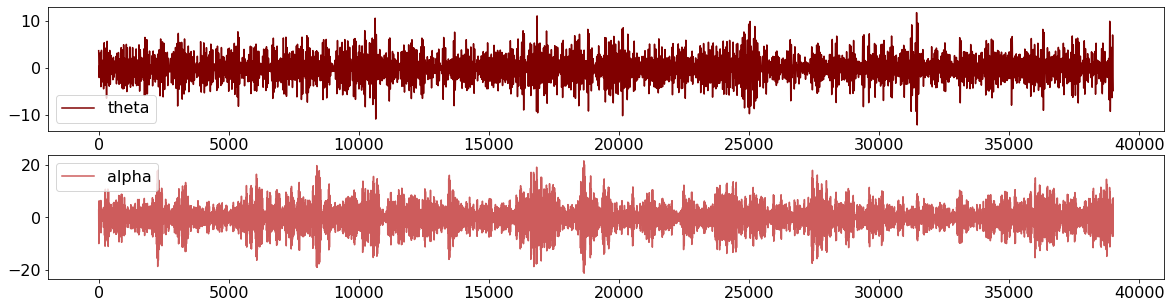

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 1, :], label='alpha', color='indianred')
plt.legend()

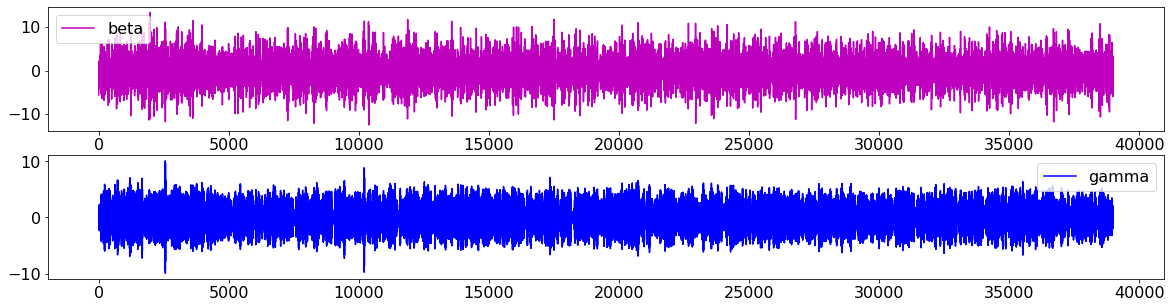

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 3, :], label='gamma', color='b')
plt.legend()

(objects, channels, bands, values) = (4, 6, 4, 40000)

# **NORMALIZE**

In [ ]:
from sklearn import preprocessing

def StandardizeByChannel(data):
  objects_data_4d_scaled = np.empty((4, channel_num, 4, values_per_file), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,4):
    for i in range(0,6):
      objects_data_4d_scaled[j, i, :, :] = preprocessing.normalize(data[j, i, :, :])
      i+=1
    j+=1  

  return objects_data_4d_scaled

In [ ]:
objects_data_4d = StandardizeByChannel(objects_data_4d)

**SPLIT**

In [ ]:
objects_data_4d_split = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, values_per_split))
j = 0

for obj in range(0, object_num):
  i = 0

  while i < values_per_file:
      objects_data_4d_split[j] = objects_data_4d[obj,:,:,i:(i+values_per_split)]
      i+=values_per_split
      j+=1

print(objects_data_4d_split)      
print(objects_data_4d_split.shape) 

[[[[ 2.70569014e-03  3.37715856e-03  3.96588473e-03 ... -9.00540426e-04
    -1.67516833e-03 -2.48234597e-03]
   [-3.48502099e-03 -2.81888946e-03 -1.93584584e-03 ... -1.70647150e-03
    -1.50260483e-03 -1.22085175e-03]
   [-1.79909569e-03 -2.99476244e-03 -3.25197212e-03 ...  1.93142247e-03
    -1.19849198e-03 -2.34077361e-03]
   [ 1.31936999e-03 -5.79097696e-03 -9.20432841e-03 ... -8.04605140e-03
    -4.04605239e-03  2.92598095e-03]]

  [[-2.24535654e-03 -2.20747229e-03 -2.13556183e-03 ... -3.25520093e-03
    -3.62438149e-03 -3.92953769e-03]
   [ 4.88987489e-03  4.53598051e-03  3.86895494e-03 ... -4.71825305e-03
    -4.32013231e-03 -3.71518706e-03]
   [-4.18194363e-03 -2.93260748e-03 -9.18194498e-05 ...  2.16027205e-03
    -8.43298229e-04 -3.40643766e-03]
   [ 9.56425622e-03  9.41361448e-03  2.47527549e-03 ...  4.21088207e-03
    -1.61900979e-03 -6.15264164e-03]]

  [[-9.59411116e-04 -5.84938333e-04 -2.06517863e-04 ... -2.67948391e-03
    -3.55550678e-03 -4.42242602e-03]
   [ 2.03413799

'c3', 'c4', 'f3', 'f4', 'p3', 'p4'

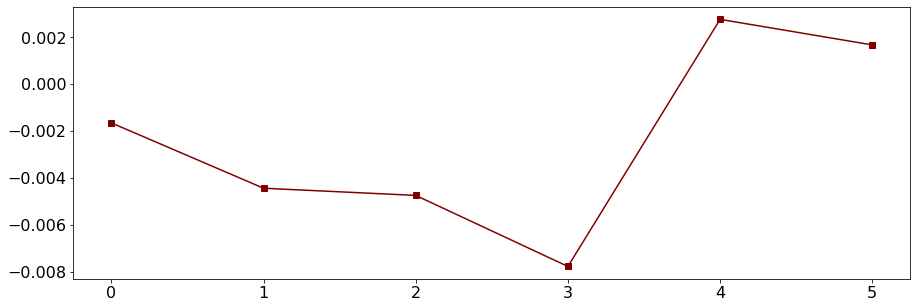

In [ ]:
b = np.array(objects_data_4d_split[1, :, 2, 0]) 
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

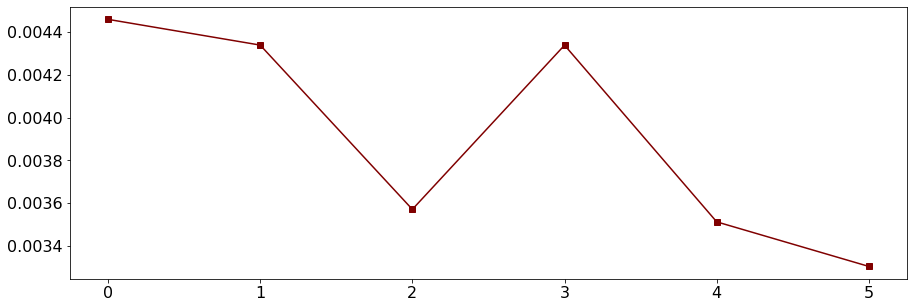

In [ ]:
b = np.array(objects_data_4d_split[5, :, 2, 0]) # joy

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

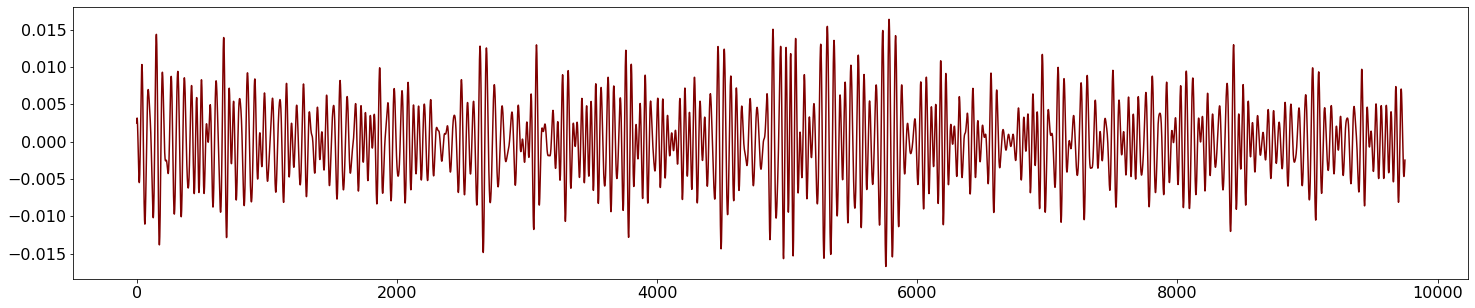

In [ ]:
b = np.array(objects_data_4d_split[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

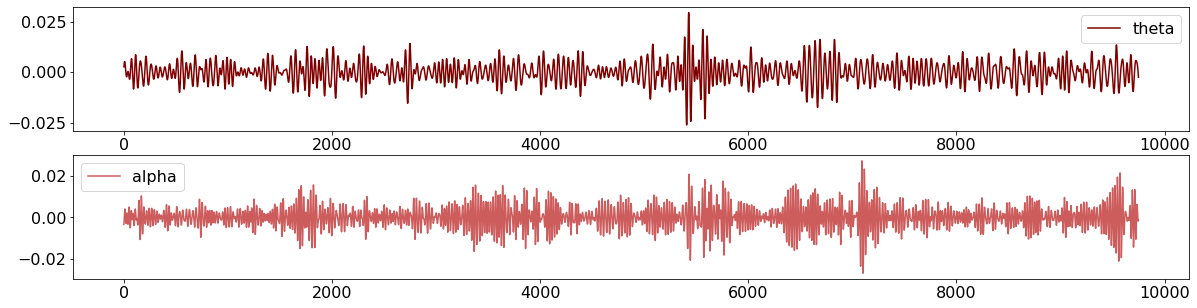

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 1, :], label='alpha', color='indianred')
plt.legend()

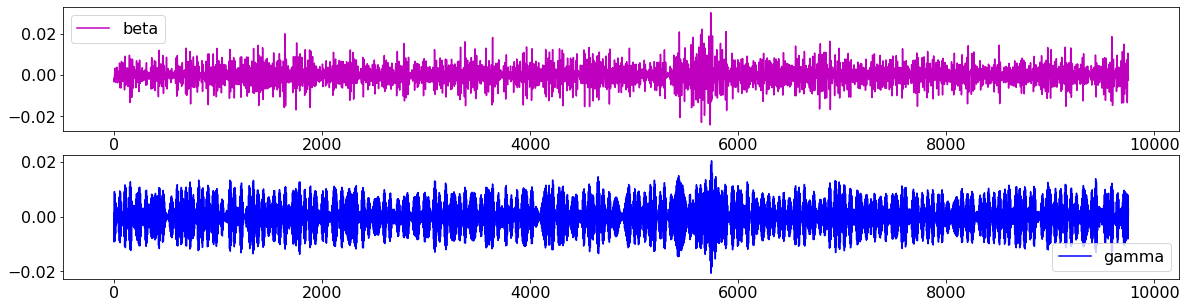

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 3, :], label='gamma', color='b')
plt.legend()

In [ ]:
objects_data_4d_split[0,:,:,:].shape

(6, 4, 9750)

In [ ]:
np.var(objects_data_4d_split[2,:,:,:])

2.5740851186969267e-05

In [ ]:
label_list = [ item for item in label_list for repetitions in range(4) ]
label_list

['fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
i=0
while i!=16:
  rat = np.var(objects_data_4d_split[i,:,:,:])/np.median(objects_data_4d_split[i,:,:,:])
  print(label_list[i], " -> ", rat)
  i+=1

fear  ->  -6.9742841466884
fear  ->  -12.382585122134994
fear  ->  2.6783383242571728
fear  ->  -6.550031025423206
joy  ->  -2.0776402317494482
joy  ->  2.632584980635654
joy  ->  -10.627792508702575
joy  ->  -2.092828480957638
joy  ->  14.638680581017237
joy  ->  -4.596341904645073
joy  ->  -4.424374342657087
joy  ->  -2.7809552515622746
fear  ->  1.37052851377124
fear  ->  7.524348663215883
fear  ->  -68.81419483452505
fear  ->  5.714578008400073


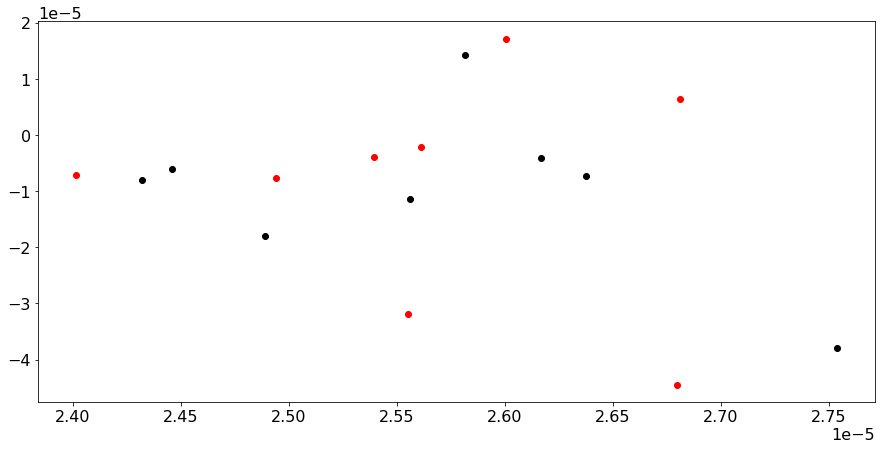

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 16})

x = np.array( [ np.var(item) for item in objects_data_4d_split[:4,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[:4,3,3,:]])
plt.plot(x, y, 'o', color='black')
x = np.array( [ np.var(item) for item in objects_data_4d_split[4:12,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[4:12,3,3,:]])
plt.plot(x, y, 'o', color='red')
x = np.array( [ np.var(item) for item in objects_data_4d_split[12:,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[12:,3,3,:]])
plt.plot(x, y, 'o', color='black')


In [ ]:
x

array([2.61664961e-05, 2.44581312e-05, 2.63778970e-05, 2.55615764e-05])

Shuffle

In [ ]:
objects_data_4d_split, label_list = shuffle(objects_data_4d_split, label_list)
print(label_list)

['joy', 'joy', 'joy', 'fear', 'joy', 'fear', 'joy', 'joy', 'joy', 'fear', 'fear', 'fear', 'joy', 'fear', 'fear', 'fear']


In [ ]:
label_list_0or1 = []
for label in label_list:
  if label == 'joy':
    label_list_0or1.append(0.)
  elif label == 'fear':
    label_list_0or1.append(1.)
    
label_list_0or1 = np.array(label_list_0or1)
print(label_list_0or1)  

[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]


1 average value per 1000 values 

In [ ]:
objects_data_4d_split_extract = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, 10))

for i in range(0, 16):
  for j in range(0, channel_num):
    for k in range(0, 4):
      for l in range(0,9):
        objects_data_4d_split_extract[i, j, k, l] = np.std(objects_data_4d_split[i, j, k, l*975:(l+1)*975])

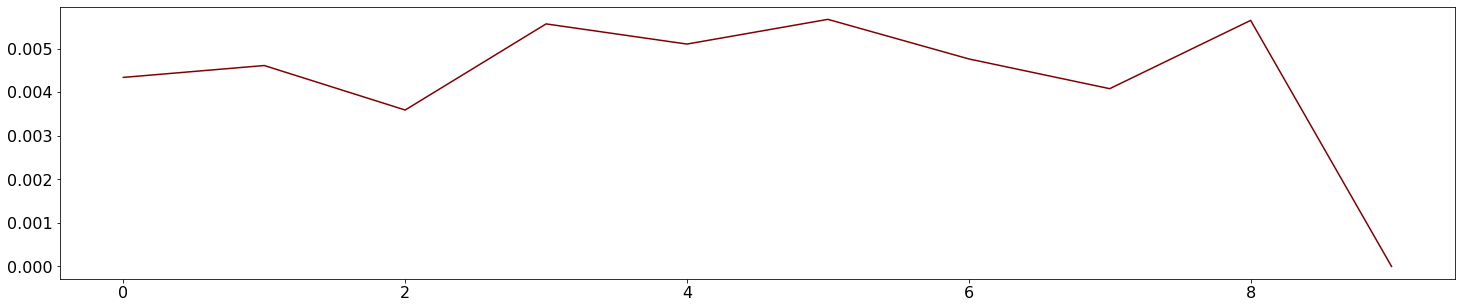

In [ ]:
b = np.array(objects_data_4d_split_extract[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

TRAIN / TEST 

In [ ]:
num_1 = 0
num_0 = 0
i = 0
index_list = []

while len(index_list)<4:
  if (label_list_0or1[i] == 0) and (num_0!=2):
    index_list.append(i)
    num_0+=1
  elif (label_list_0or1[i] == 1) and (num_1!=2): 
    index_list.append(i)
    num_1+=1
  i+=1
print(i)

6


In [ ]:
x_test = objects_data_4d_split_extract[index_list,:]
y_test = label_list_0or1[index_list]
print(y_test)

[0. 0. 1. 1.]


In [ ]:
x_test

array([[[[0.00494311, 0.00559389, 0.00418883, 0.00538764, 0.00455143,
          0.00466664, 0.00419731, 0.00558077, 0.00434313, 0.        ],
         [0.00460722, 0.00477042, 0.00525395, 0.00559205, 0.00472864,
          0.00442565, 0.00589486, 0.00527573, 0.00509676, 0.        ],
         [0.00526876, 0.00529158, 0.00488485, 0.00550205, 0.00503161,
          0.00460697, 0.00525637, 0.00555648, 0.00517762, 0.        ],
         [0.00497697, 0.00507481, 0.0050405 , 0.00514441, 0.00517112,
          0.00490173, 0.0052585 , 0.00524395, 0.00502012, 0.        ]],

        [[0.00576067, 0.0057917 , 0.00427705, 0.00522114, 0.00464971,
          0.00457902, 0.00461577, 0.00649207, 0.00444517, 0.        ],
         [0.00475875, 0.00521337, 0.00532033, 0.00557652, 0.00486021,
          0.00402758, 0.00587904, 0.0056154 , 0.00541983, 0.        ],
         [0.00530946, 0.00520645, 0.004935  , 0.00534277, 0.00517807,
          0.00449771, 0.00507801, 0.00555574, 0.00509981, 0.        ],
         [0

In [ ]:
x_train = np.delete(objects_data_4d_split_extract, index_list, 0)
y_train = np.delete(label_list_0or1, index_list)
print(x_train.shape)

(12, 6, 4, 10)


Reshape Data

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1,1))

In [ ]:
y_train

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[1.]]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='tanh', input_shape=(channel_num, 4, 10)))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
#model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 2, 32)          2912      
                                                                 
 dense (Dense)               (None, 4, 2, 16)          528       
                                                                 
 dense_1 (Dense)             (None, 4, 2, 8)           136       
                                                                 
 dense_2 (Dense)             (None, 4, 2, 1)           9         
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


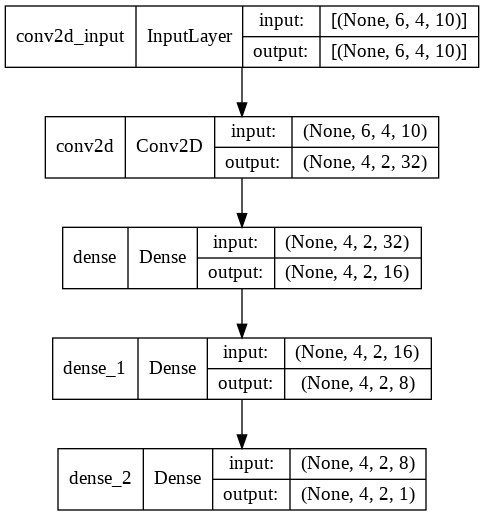

In [ ]:
plot_model(model, to_file=(model_path+'NNmodel_plot.png'), show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=4, validation_data = (x_test, y_test))

Epoch 1/1000
3/3 [==============================] - 1s 110ms/step - loss: 0.6957 - accuracy: 0.3333 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5625
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6932 - accuracy: 0.4896 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5625
Epoch 7/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.4896 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/1000

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 22ms/step - loss: 0.1795 - accuracy: 0.9062
Accuracy: 90.62


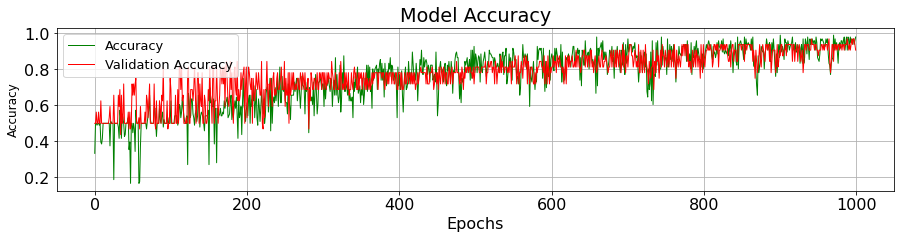

In [ ]:
plt.figure(figsize=(15,3), frameon=True)
plt.rcParams.update({'font.size': 16})

plt.plot(history.history['accuracy'], 'g', linewidth=1)
plt.plot(history.history['val_accuracy'], 'r', linewidth=1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

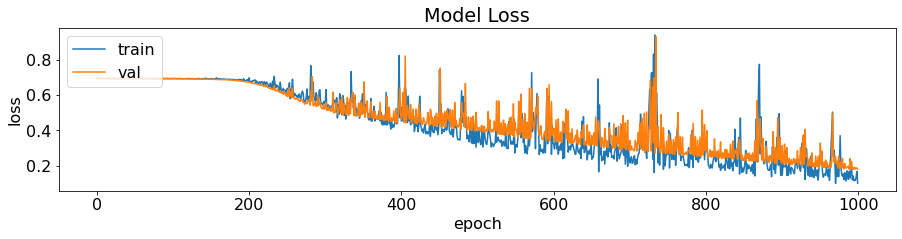

In [ ]:
plt.figure(figsize=(15,3), frameon=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Figure size 1080x360 with 0 Axes>

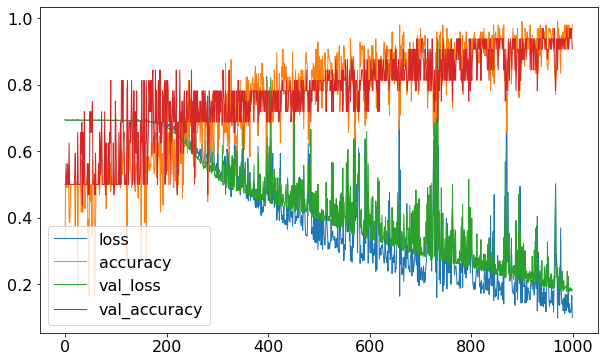

In [ ]:
plt.figure(figsize=(15,5), frameon=True)
pd.DataFrame(history.history).plot(figsize=(10,6),linewidth=1)
plt.show()

In [ ]:
model.save(os.path.join(model_path, (model_name + '_MODEL.h5')))
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open((model_path + model_name + '_MODEL.json'), "w") as json_file:
    json_file.write(model_json)

Saved trained model at /content/drive/MyDrive/Brain/EEG_Models/ 


In [ ]:
json_file = open(model_path + model_name + '_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_path + model_name + '_MODEL.h5')
print("Loaded model from disk")

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk
